## Towards understanding the relationship between the availability of mental health care and the incidence of crime. A statistical exploration of USA healthcare shortage areas and reported crime data from the FBI Crime database. 
### Author: Eric J. Chan
### Date: 2/4/2023

In the following study, we will attempt to gain any insight as to if the inaccesability of mental heath care services in a particular area had any influence on the crime rate. We will start with a more general study that involves summary statistics for the last few decades  and then focus on specific health shortage areas with data avalable within certain time periods. 

The study uses two sources of data which both require interfacing with API:

1. Data on US health provider shortage areas, specifically mental health. The origin is from the US  Health Resources & Services Administration.(see https://data.hrsa.gov/topics/health-workforce/shortage-areas#) The data is more conveniently available to the general public in the form of an interactive webpage dashboard (see below).
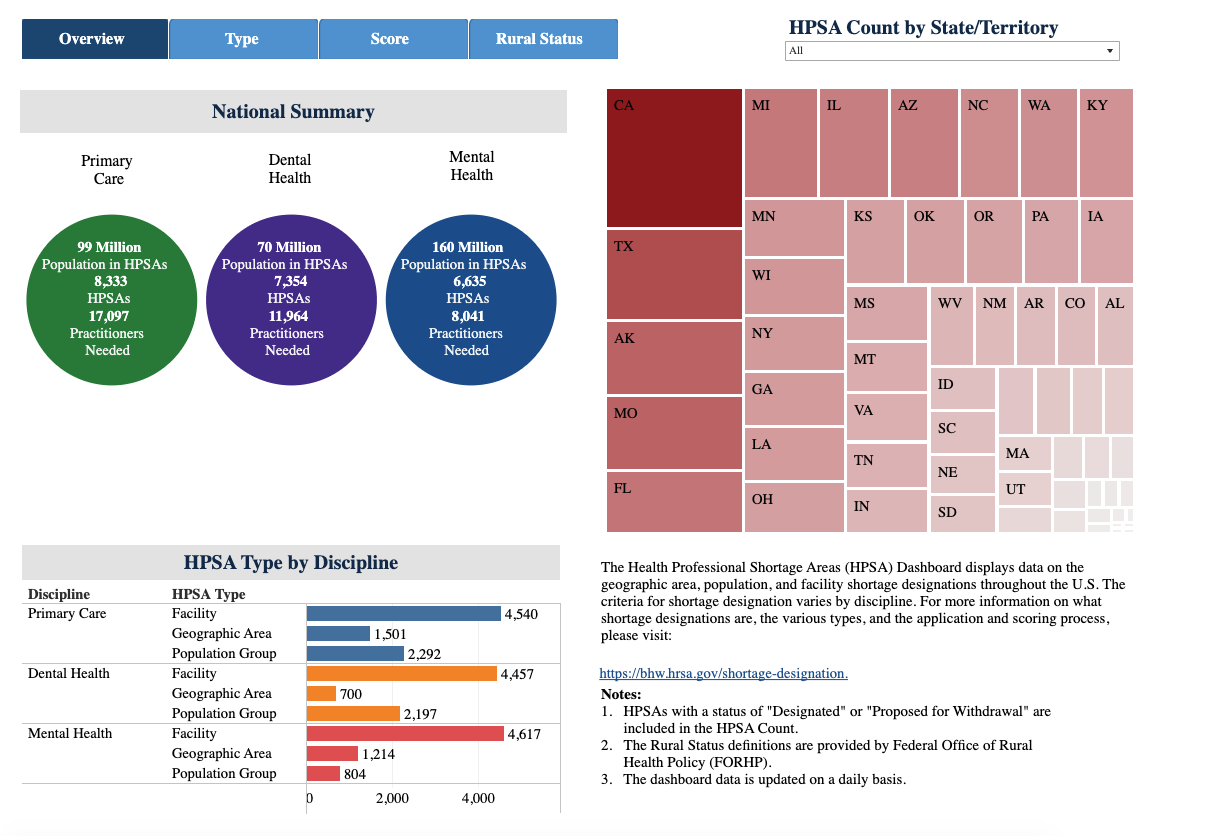


2. Data on crime incident is made available from the USA government's FBI Crime Data Explorer with the FBI Crime Data API.(https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/docApi) The explorer itself is a web-based tool for the general public.The FBI's Crime Data Explorer (CDE) aims to provide transparency, create easier access, and expand awareness of criminal, and noncriminal, law enforcement data sharing; improve accountability for law enforcement; and provide a foundation to help shape public policy with the result of a safer nation. Use the CDE to discover available data through visualizations, download data in .csv format, and other large data files.
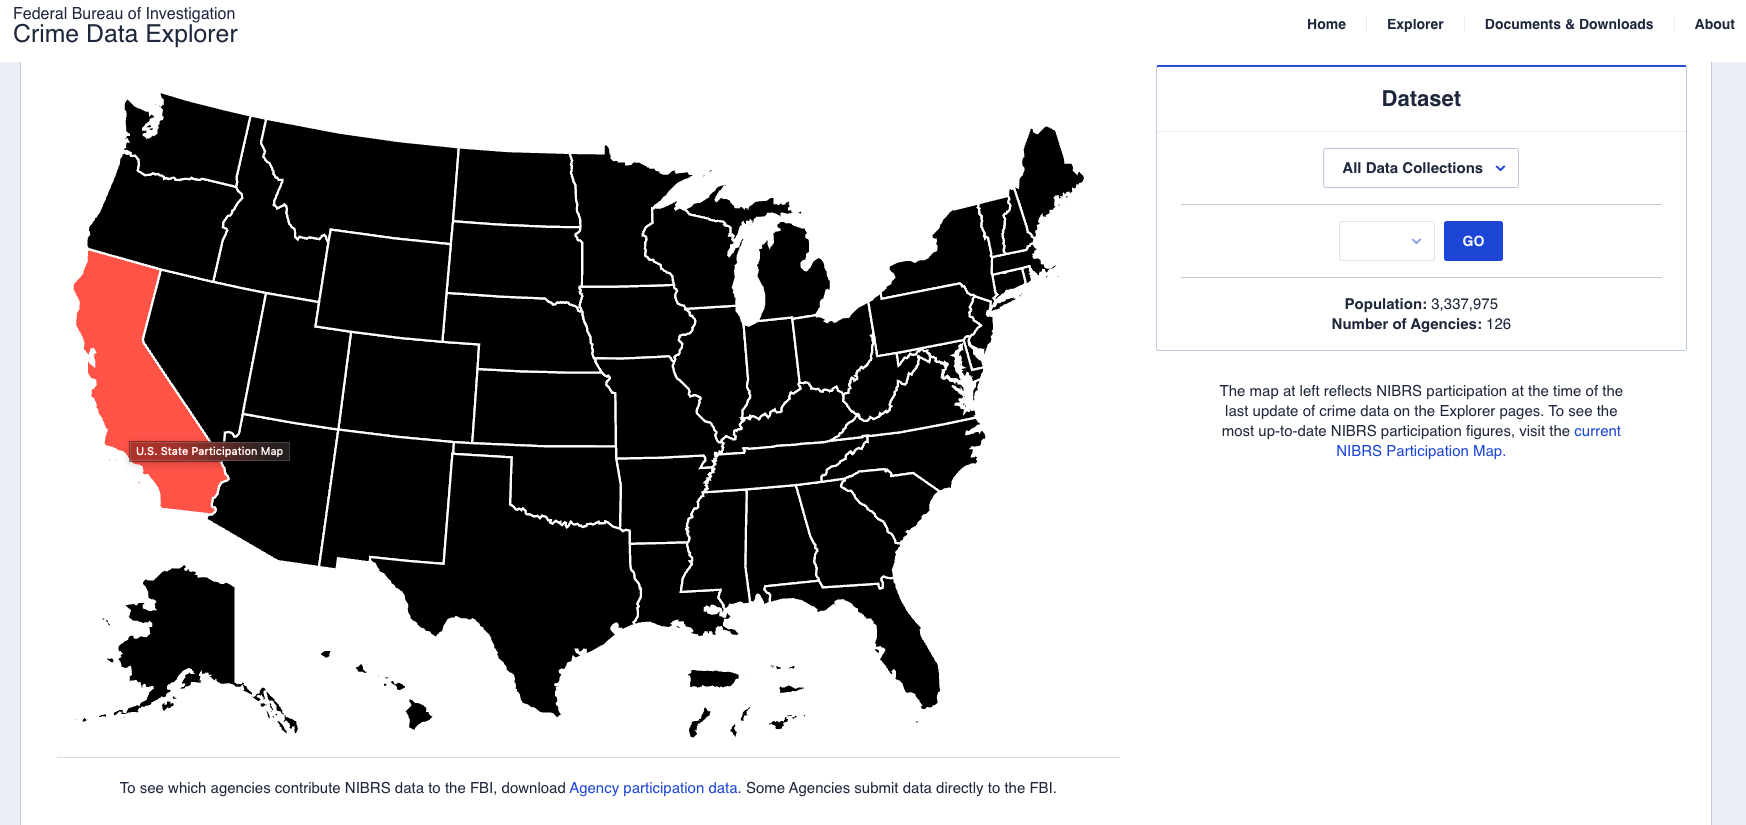


A bigger picture idea (work-in-progress) could be a data visualisation of a combination of both of the above-mentioned web-based tools.
For this mini-project, we will start with some more simplistic EDA and identify the outcomes of simple AB hypothesis testing.
__Our Question is related to this null hypothesis ($H_0$):__ "That, in general, there is no relationship between any shortage of mental health services and the incidence of crime".




The first dataset is a table we will refer to as the Mental Health Shortage Area (MHSA) table, specifically with data on areas in the USA with mental Heath care shortages and was available from the Google Cloud Marketplace made accessible via BigQuery. 

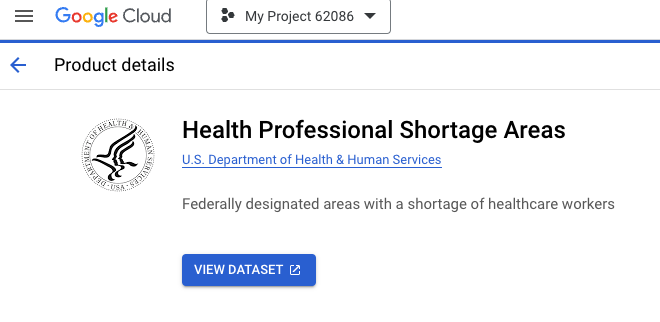

Health Professional Shortage Areas (HPSAs) are federal designations that indicate health care provider shortages. 
HRSA’s Bureau of Health Workforce (BHW) develops shortage designation criteria and uses them to decide whether or not a geographic area or population group is a Health Professional Shortage Area (HPSA), Medically Underserved Area (MUA), or Medically Underserved Population (MUP).

__Table ID:__ bigquery-public-data.sdoh_hrsa_shortage_areas.hpsa_mental_health 

The table has many fields, which, for our purposes, are currently not necessary.
Number of rows: 24,452
Total logical bytes: 13.76 MB 

will will extract the entire table using the the python interface for google cloud and save this localy as an sqlite3  database


The other data we will extract as required using the FBI Crime Data API 
https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/docApi
The FBI Crime Data API is a read-only web service that returns JSON or CSV data. It is broadly organized around the data reporting systems the FBI UCR program uses and their related entities. Agencies submit data using one of two reporting formats -- the Summary Reporting System (SRS), or the National Incident Based Reporting System (NIBRS). SRS data is the legacy format that provides aggregated counts of the reported crime offenses known to law enforcement by location.
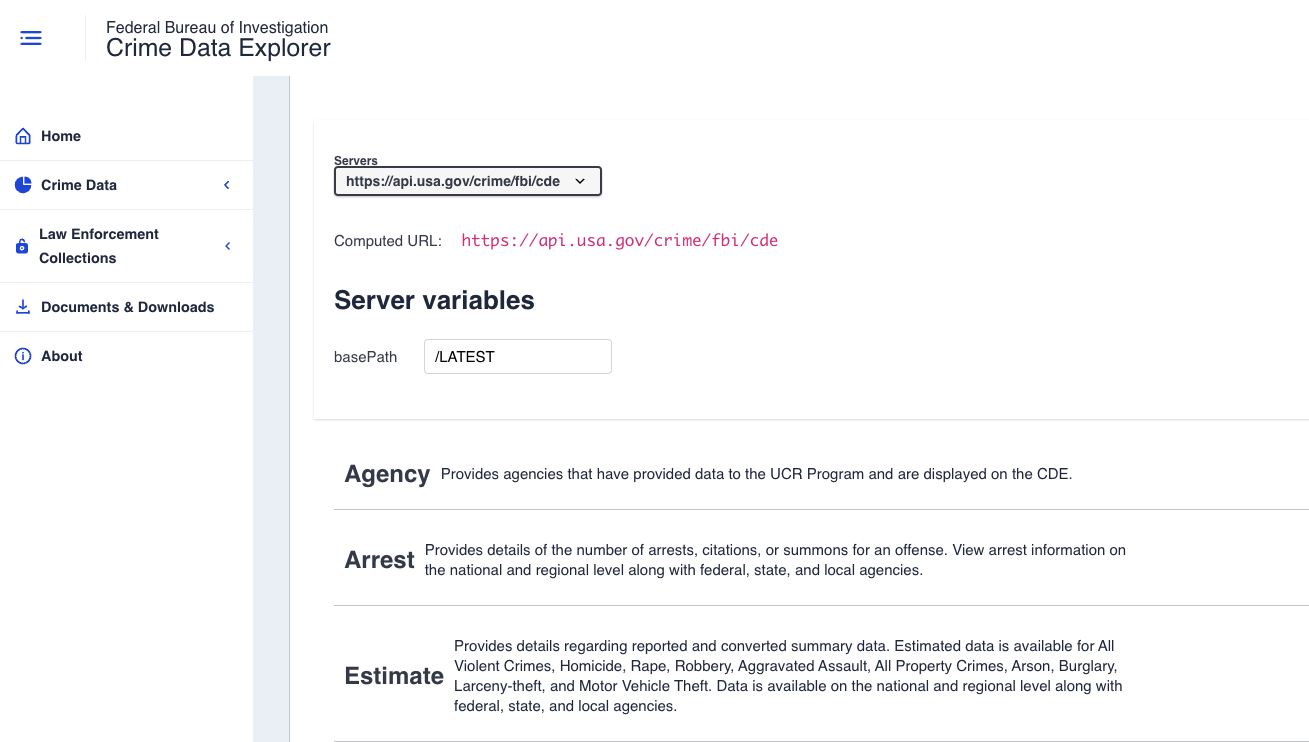


__We will use three of the avaliable API functions:__

1. __Agency -__
Provides agencies that have provided data to the UCR Program and are displayed on the CDE.
2. __Estimate -__
Provides details regarding reported and converted summary data. Estimated data is available for All Violent Crimes, Homicide, Rape, Robbery, Aggravated Assault, All Property Crimes, Arson, Burglary, Larceny-theft, and Motor Vehicle Theft. Data is available on the national and regional level along with federal, state, and local agencies. This includes information about the population size but 
is only avaliable either national or for each state. 
3. __Arrest -__
Provides details of the number of arrests, citations, or summons for an offense. View arrest information on the national and regional level along with federal, state, and local agencies. This includes information about the population size and requires an agency code as input. 

Crime data from this API is further categorised by type, which we will sum to obtain totals.

#### IMPORTANT NOTE:
The FBI Crime Data API is a read-only web service that returns JSON or CSV data. It is broadly organized around the data reporting systems the FBI UCR program uses and their related entities. 
__Agencies submit data using one of two reporting formats__ 
- the Summary Reporting System (SRS): SRS data is the legacy format that provides aggregated counts of the reported crime offenses known to law enforcement by location.
- the National Incident Based Reporting System (NIBRS): NIBRS is a newer format that provides an incident-based view of crime. It includes information about each offense, such as the time of day an incident occurred, the demographics of the offenders/victims, the known relationships between the offenders and victims, and many other details around how and where crime occurs. Neither format includes personally identifiable information (PII) about the offenders or victims. While many agencies submit SRS data, the FBI plans to transition all crime reporting to the NIBRS format by 2021.



### Import modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Cause plots to be displayed in the notebook:
%pylab inline
%matplotlib inline

import requests
import json

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sqlite3
from pandas.io import sql
sqlite_db = 'miniproject_db.sqlite'
conn = sqlite3.connect(sqlite_db) 
c = conn.cursor()

In [3]:
import folium
from folium.plugins import HeatMap

In [3]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [6]:
key_path = './marine-fusion-381400-bcd419f0d93b.json'

In [7]:
''' The following code grabs the table data from the cloud   '''
from google.cloud import bigquery
myclient = bigquery.Client.from_service_account_json(key_path, project = 'marine-fusion-381400')


In [8]:
sql = ''' SELECT *   FROM `bigquery-public-data.sdoh_hrsa_shortage_areas.hpsa_mental_health` ;'''
query_job = myclient.query(sql)
dfbig = query_job.to_dataframe()
dfbig.head(1)

,Source_ID,Source_Name,Status_Code,Status_Description,Type_Code,Type_Desc,Address,City,State_Abbr,Postal_Code,...,Common_State_Name,Common_State_FIPS,Common_Region_Name,HPSA_Withdrawn_Date,HPSA_Withdrawn_Date_String,Provider_Type,Rural_Status_Code,Rural_Status_Desc,HPSA_Designation_Pop_Type_Desc,BHCMIS_OrgID
0,733007,Coos,W,Withdrawn,Hpsa Geo,Geographic HPSA,None,None,NH,None,...,New Hampshire,33,Region I,2003-06-27,6/27/2003,None,R,Rural,Geographic Population,None


In [37]:
''' 
access the MHSA table schema which was avaliable online as .json 
This contains information about the many fields in the table

'''
with open('hpsa_mh_schema.json','r') as f:
    mhschema = json.load(f)
mhschema=pd.DataFrame(mhschema)



## We will create a shortlist version of the MHSA table using selected fields

| Field    | Description                              |
|----------|-------------------------------------------:|
| Address    | Standardized version of the street address of a Health Professional Shortage Area (HPSA) facility. |
| City       |Standardized version of the city name in which a Health Professional Shortage Areas (HPSA) facility is located.|
| State_Abbr | U.S. Postal Service (USPS) code for the state in which the Health Professional Shortage Area (HPSA) entity is located.|
| County_Name |Name of the county or county equivalent in which the associated address is located, displayed as a text string.|
| Postal_Code |Health Professional Shortage Area (HPSA) U.S. Postal Service (USPS) Zoning Improvement Plan (ZIP) Code. In the context of HPSA data, this field only applies to facilities.|
| Type_Desc |Textual description of the Health Professional Shortage Area (HPSA) type.|
| Degree_of_Shortage | Degree of practitioner shortage for the Health Professional Shortage Area (HPSA) based on population to provider ratio.|
| Status_Code | One character identifier that designates the current status of the HPSA designation. For further information about Health Professional Shortage Areas (HPSA) refer to the http://www.hrsa.gov/shortage/ website.|
| Status_Description| Textual description of the current status of the Health Professional Shortage Area (HPSA) designation.|
| HPSA_Score | Health Professional Shortage Area (HPSA) Score developed by the National Health Service Corps (NHSC) in determining priorities for assignment of clinicians. The scores range from 0 to 26 where the higher the score, the greater the priority.|
| Designation_Date | Date on which the Health Professional Shortage Area (HPSA) was originally designated as a shortage area.|
| HPSA_Withdrawn_Date | Date on which the designation status was changed from designated to withdrawn. |
| Geocoding_Primary_Y | Primary latitude in decimal degrees (y coordinate) of an entity based on its address. | 
| Geocoding_Primary_X | Primary longitude in decimal degrees (x coordinate) of an entity based on its address.  |  



The data we are most interested in for our study concerns MHSA location (lat,long), designation date, withdrawal date, degree of shortage, HPSA score, and status description, which must be currently 'withdrawn'. This is because we want to see if the mental health care presence has any impact on the crime rate. An alternative hypothesis might be "that crime is reduced in an area now that there are enough mental health services". Knowing both designation dates and withdrawal dates will be used as criteria for grouping AB tests. We will also perfrom EDA to see if there is some relationship between the Degree_of_Shortage and Degree_of_Shortage with crime.   


It is interesting to note the different types of mental heath shortage areas listed in the table.

In [4]:
query = """ SELECT  Type_Desc as mental_heath_shortage_area_type, count(1) as number_of_entries FROM hpsa_mental_health_full  GROUP BY Type_Desc """
test_count = sql.read_sql(query, con=conn)
test_count

,mental_heath_shortage_area_type,number_of_entries
0,Correctional Facility,881
1,Federally Qualified Health Center,1528
2,Federally Qualified Health Center Look A Like,186
3,Geographic HPSA,5592
4,HPSA Population,8728
5,High Needs Geographic HPSA,4353
6,"Indian Health Service, Tribal Health, and Urba...",719
7,"Indian, Tribal and Urban Indian Organizations",194
8,Other Facility,156
9,Rural Health Clinic,1911


In [5]:
# now run the query on the full table stored locally 
# this will generate the short listing of metal health shortage areas
# labeled as mh and stored as pandas df that we can further operate on
query = """

    SELECT Address,City,State_Abbr,County_Name,Postal_Code,Type_Desc,
           Degree_of_Shortage,Status_Code,Status_Description,HPSA_Score, Designation_Date,
           Component_Designation_Date,HPSA_Withdrawn_Date,
           Geocoding_Primary_Y as latitude,
        Geocoding_Primary_X as longitude   
    FROM  hpsa_mental_health_full
    WHERE 
        NOT Address IS NULL
    AND 
        NOT Degree_of_Shortage IS NULL
    AND 
        NOT HPSA_Score IS NULL
  --  AND 
  --      NOT Designation_Pop IS NULL
    AND
        Status_Description = 'Withdrawn'
    ORDER BY Degree_of_Shortage DESC
  --  LIMIT 100;
        """

mh = sql.read_sql(query, con=conn)
mh.head(5)

,Address,City,State_Abbr,County_Name,Postal_Code,Type_Desc,Degree_of_Shortage,Status_Code,Status_Description,HPSA_Score,Designation_Date,Component_Designation_Date,HPSA_Withdrawn_Date,latitude,longitude
0,24900 Highway 202,Tehachapi,CA,Kern,93561-5558,Correctional Facility,7.6,W,Withdrawn,6,2005-03-07,None,2019-06-25,35.125864,-118.574113
1,5th St & Western Ave,Norco,CA,Riverside,92860,Correctional Facility,6.1,W,Withdrawn,6,2000-08-31,None,2019-06-25,33.931116,-117.576657
2,201 W Main St,Niantic,CT,New London,06357-1014,Correctional Facility,6,W,Withdrawn,15,2016-07-19,None,2019-06-25,41.319242,-72.232972
3,251 N ILLINOIS H,Ina,IL,Jefferson,62846,Correctional Facility,6,W,Withdrawn,15,2007-08-10,None,2019-06-25,38.150588,-88.871159
4,3259 Val Tech Rd,Valdosta,GA,Lowndes,31602-9309,Correctional Facility,6,W,Withdrawn,15,2016-06-24,None,2019-06-25,30.858241,-83.342989


In [17]:
print("%i entries in MHSA short list"%len(mh))
mh['Type_Desc'].value_counts()
# turns out Area types are Correctional Facilities  

113 entries in MHSA short list


Correctional Facility    113
Name: Type_Desc, dtype: int64

### Saving this shortlist as a seperate table under miniproject_db.sqlite

In [416]:
## mh.to_sql('MH_shortages_withdrawn', con = conn, if_exists = 'replace', index = False)

In [897]:
## mh.to_csv('./tableau_datafiles/MH_shortages_withdrawn.csv', index = False)

In [7]:
### load directly from csv for later use
## mh=pd.read_csv('./tableau_datafiles/MH_shortages_withdrawn.csv')

We will now group and aggregate the areas for each state 

In [113]:
query = """

SELECT State_Abbr , count(1) as number, AVG(Degree_of_Shortage) as  averaged_Degree_of_Shortage,
AVG(HPSA_Score) as  averaged_HPSA_Score, MIN(Designation_Date),MAX(Designation_Date),AVG(Designation_Date),
MIN(HPSA_Withdrawn_Date),MAX(HPSA_Withdrawn_Date),AVG(HPSA_Withdrawn_Date)
FROM MH_shortages_withdrawn 
GROUP BY State_Abbr 
ORDER BY averaged_Degree_of_Shortage DESC
;
        """
myquery = sql.read_sql(query, con=conn)
myquery.head(2)

,State_Abbr,number,averaged_Degree_of_Shortage,averaged_HPSA_Score,MIN(Designation_Date),MAX(Designation_Date),AVG(Designation_Date),MIN(HPSA_Withdrawn_Date),MAX(HPSA_Withdrawn_Date),AVG(HPSA_Withdrawn_Date)
0,WI,1,12.0,21.0,2009-11-18,2009-11-18,2009.0,2019-06-25,2019-06-25,2019.0
1,WA,1,12.0,12.0,2009-11-18,2009-11-18,2009.0,2019-06-25,2019-06-25,2019.0


In [21]:
# getting the list of states from the MH_shortages_withdrawn table
mhs_us_states=(myquery['State_Abbr'].values).astype(str)
mhs_us_states

array(['WI', 'WA', 'OR', 'OK', 'OH', 'NM', 'NJ', 'KS', 'IN', 'AK', 'TX',
       'VA', 'CO', 'KY', 'CA', 'NE', 'PA', 'MD', 'GA', 'CT', 'FL', 'ID',
       'IA', 'IL', 'MN', 'AL', 'NC', 'HI', 'AR'], dtype='<U2')

In [22]:
# we will try max designation dates as bounds for an A B grouping with t-test
max_designation_Date=np.array([s.split('-') for s in myquery['MAX(Designation_Date)'].values.astype(str)])[:,0]
max_designation_Date

array(['2009', '2009', '2009', '2009', '2015', '2016', '2009', '2009',
       '2007', '2016', '2017', '2016', '2015', '2009', '2012', '2016',
       '2009', '2001', '2016', '2016', '2009', '2009', '2015', '2007',
       '2004', '2008', '2009', '2002', '2009'], dtype='<U4')

In [130]:
# we will also try two years prior av withdrall date as bounds for an A B grouping with t-test
# subtract 2-years from this date as a manual offset.  
avg_withdrawal_Date=np.array([s.split('-') for s in myquery['AVG(HPSA_Withdrawn_Date)'].values.astype(str)])[:,0]
avg_withdrawal_Date=np.round(avg_withdrawal_Date.astype(float)-2).astype(int).astype(str)
avg_withdrawal_Date

array(['2017', '2017', '2017', '2017', '2017', '2017', '2017', '2017',
       '2017', '2015', '2017', '2017', '2017', '2017', '2017', '2017',
       '2017', '2017', '2017', '2017', '2017', '2017', '2017', '2017',
       '2017', '2017', '2017', '2017', '2017'], dtype='<U21')

In [117]:
# we need to spcifiy an overall time period range for the data
# we can use the minimum Designation Date from our MHSA table (mhs_us_states)
# and try collect up until last year 2022 
myquery['MIN(Designation_Date)'].min()

'1979-05-16'

### We are using the __estimate__ function from the API to gather FBI Summary Reporting System (SRS) data from selected states (time period 1979-2022) which we save as .json for later processing


###  Evaluating crime data for each state  
Defined A function that will take as inputs the crime estimate data as .json and date 
to act as the bounds for AB grouping of the crime data where A:'before input date'
B:'after input date'. 
In this case we must bear in mind that the $H_0$ here is simply "That there was no differnce in average crime rate before or after a specified date", which was not our intended $H_0$
The function does the sumations, AB grouping and calculates the T-test for the means of the
two groups using scipy.stats.ttest_ind(). The function returns a dataframe with total crime for each year 
from 1979 thru 2022 (pre-specified), p-value, group A mean, group B mean.

In [121]:
def process_crime_usa_state_crime_data(est_crime,my_designation_date):
    '''
    This processes crime data beacuse there are revised entires for the rape counts.
    We also perfrom the t-test based on an input designation date 
    '''
    # for this states crime data create the two groups A=before MHS B= after MHS  
    # my_designation_date=1990
    # created a new col that is a duplicate of target 
    est_crime["rape_new"]=[i for i in range(len(est_crime))]
    # this will use the revise rape score 
    est_crime["rape_new"]= est_crime["rape_new"].apply(lambda x: est_crime['rape_legacy'][x] if est_crime['rape_revised'][x] is None else est_crime['rape_revised'][x])
    total_crime=est_crime.drop(['state_id','state_abbr','year','population','rape_legacy','rape_revised'],axis=1).astype(int).sum(axis=1)
    est_crime_tot=pd.concat([est_crime[['year','population']],total_crime],axis=1)
    est_crime_tot.columns=['year','population','total_crime']
    est_crime_tot["crime_rate_per_year"]=est_crime_tot['total_crime']/est_crime_tot['population'].astype(int)
    est_crime_tot["isMHS"]=est_crime_tot['year'].astype(int)
    est_crime_tot["isMHS"]=est_crime_tot["isMHS"].apply(lambda x: 'before' if x <= my_designation_date else 'after' )

    # this does the t-test
    group_a_scores=est_crime_tot[est_crime_tot["isMHS"]=='before'].crime_rate_per_year.values
    group_b_scores=est_crime_tot[est_crime_tot["isMHS"]=='after'].crime_rate_per_year.values
    t_statistic, p_value = stats.ttest_ind(group_a_scores, group_b_scores)
   
    return est_crime_tot,p_value,np.mean(group_a_scores),np.mean(group_b_scores)
    

Initialize a df to store the crime data for each state. Apply the function for each state using the list 
max_designation_Date for the AB groupings.  

In [125]:
# create a seperate table to store colums from different states 
est_crime_tot_all_states=pd.DataFrame()

In [122]:
# lets read in some crime data
# first check columns for state data is the same 
# initalize lists to store p_values and grouped averages for EDA
pvals_max_des_date=[]
av_crime_A_bndmaxs=[]
av_crime_B_bndmaxs=[]
for idx,state in enumerate(mhs_us_states):
    filename=('estimate_crime_%s_%s_%s.json'%(state,'1979','2020'))
    with open('./data/%s'%(filename), 'r') as file:
            crime_dat=json.load(file)
    est_crime=pd.DataFrame(crime_dat)
  #  print(est_crime.head())
    print(state,len(est_crime.columns),est_crime.columns)
  #  print(max_designation_Date[idx])
    est_crime_tot,p_value,av_crime_A_bndmax,av_crime_B_bndmax = process_crime_usa_state_crime_data(est_crime,int(max_designation_Date[idx]))
    print(p_value,av_crime_A_bndmax,av_crime_B_bndmax)
    pvals_max_des_date.append(p_value)
    av_crime_A_bndmaxs.append(av_crime_A_bndmax)
    av_crime_B_bndmaxs.append(av_crime_B_bndmax)
    est_crime_tot_all_states[state]=est_crime_tot['crime_rate_per_year']

WI 15 Index(['state_id', 'state_abbr', 'year', 'population', 'violent_crime',
       'homicide', 'rape_legacy', 'rape_revised', 'robbery',
       'aggravated_assault', 'property_crime', 'burglary', 'larceny',
       'motor_vehicle_theft', 'arson'],
      dtype='object')
1.0192265698370678e-09 0.07601476620463421 0.0458563670609603
WA 15 Index(['state_id', 'state_abbr', 'year', 'population', 'violent_crime',
       'homicide', 'rape_legacy', 'rape_revised', 'robbery',
       'aggravated_assault', 'property_crime', 'burglary', 'larceny',
       'motor_vehicle_theft', 'arson'],
      dtype='object')
3.483573466911697e-10 0.11714197497664974 0.07334846619861156
OR 15 Index(['state_id', 'state_abbr', 'year', 'population', 'violent_crime',
       'homicide', 'rape_legacy', 'rape_revised', 'robbery',
       'aggravated_assault', 'property_crime', 'burglary', 'larceny',
       'motor_vehicle_theft', 'arson'],
      dtype='object')
4.505153345909671e-09 0.11404721981587851 0.06558332561344375
O

Initialize a df to store the crime data for each state. Apply the function for each state now using the list 
avg_withdrawal_Date for the AB groupings.  (keeping in mind we offset this date by -2 years )

In [127]:
# create a seperate table to store colums from different states 
est_crime_tot_all_states=pd.DataFrame(est_crime_tot['year'])

In [128]:
# lets read in some crime data
# lets read in some crime data
# first check columns for state data is the same 
# initalize lists to store p_values and grouped averages for EDA
# we will see effect for grouping on different dates  
pvals_ave_withdraw_date=[]
av_crime_As=[]
av_crime_Bs=[]
for idx,state in enumerate(mhs_us_states):
    filename=('estimate_crime_%s_%s_%s.json'%(state,'1979','2020'))
    with open('./data/%s'%(filename), 'r') as file:
            crime_dat=json.load(file)
    est_crime=pd.DataFrame(crime_dat)
  #  print(est_crime.head())
    print(state,len(est_crime.columns),est_crime.columns)
  #  print(max_designation_Date[idx])
    est_crime_tot,p_value,av_crime_A,av_crime_B = process_crime_usa_state_crime_data(est_crime,int(avg_withdrawal_Date[idx]))
    print(p_value,av_crime_A,av_crime_B)
    pvals_ave_withdraw_date.append(p_value)
    av_crime_As.append(av_crime_A)
    av_crime_Bs.append(av_crime_B)
    est_crime_tot_all_states[state]=est_crime_tot['crime_rate_per_year']

WI 15 Index(['state_id', 'state_abbr', 'year', 'population', 'violent_crime',
       'homicide', 'rape_legacy', 'rape_revised', 'robbery',
       'aggravated_assault', 'property_crime', 'burglary', 'larceny',
       'motor_vehicle_theft', 'arson'],
      dtype='object')
0.00044000395407472407 0.07055488687580294 0.0364124006193031
WA 15 Index(['state_id', 'state_abbr', 'year', 'population', 'violent_crime',
       'homicide', 'rape_legacy', 'rape_revised', 'robbery',
       'aggravated_assault', 'property_crime', 'burglary', 'larceny',
       'motor_vehicle_theft', 'arson'],
      dtype='object')
0.0008614043276595928 0.10900073949379464 0.06240183740095908
OR 15 Index(['state_id', 'state_abbr', 'year', 'population', 'violent_crime',
       'homicide', 'rape_legacy', 'rape_revised', 'robbery',
       'aggravated_assault', 'property_crime', 'burglary', 'larceny',
       'motor_vehicle_theft', 'arson'],
      dtype='object')
0.010422710243519302 0.10438715064046412 0.061927173687337994
O

In [18]:
# save the est crime table as .csv
# est_crime_tot_all_states.to_csv('./data/est_crime_tot_all_states.csv',index=False)
test=pd.read_csv('./data/est_crime_tot_all_states.csv')
# est_crime_tot_all_states=test.copy()  # only do this if reloading
# est_crime_tot_all_states.head()

,year,WI,WA,OR,OK,OH,NM,NJ,KS,IN,...,CT,FL,ID,IA,IL,MN,AL,NC,HI,AR
0,1979,0.088061,0.131029,0.128029,0.094400,0.103087,0.117083,0.116747,0.098308,0.092401,...,0.115745,0.154058,0.085106,0.086315,0.120787,0.088212,0.084944,0.087703,0.145081,0.072601
1,1980,0.096379,0.138813,0.134359,0.101654,0.109260,0.120146,0.128827,0.108123,0.099006,...,0.118373,0.168450,0.095992,0.095406,0.125813,0.096371,0.098960,0.093150,0.149961,0.076498
2,1981,0.095653,0.135337,0.141338,0.097226,0.109568,0.124271,0.124325,0.108509,0.091103,...,0.117281,0.161035,0.090901,0.094761,0.122754,0.095086,0.098280,0.090743,0.130933,0.076147
3,1982,0.089052,0.126082,0.131933,0.104930,0.099249,0.132831,0.114137,0.099455,0.088903,...,0.109014,0.149646,0.081928,0.083028,0.117156,0.089421,0.092944,0.091171,0.132127,0.077699
4,1983,0.085342,0.121995,0.125527,0.099034,0.090617,0.127236,0.103731,0.090945,0.082900,...,0.099948,0.135927,0.077585,0.078664,0.111191,0.080925,0.082269,0.083945,0.116669,0.070194


In [74]:
# tranpose data and save in case we need the transposed version - I have saved this locally already 
est_transpose=est_crime_tot_all_states.set_index('year').T
# est_transpose.to_csv('./tableau_datafiles/Transpose_tot_all_states.csv',index=True)
# est_transpose.drop('index')
# est_transpose=est_transpose.reset_index()
# est_transpose.index
# est_transpose.to_sql('est_crime_totals_per_state', con = conn, if_exists = 'replace', index = False)

### Appending the p-values and averages onto the MHSA grouped data table 

In [36]:
# print(pvals_ave_withdraw_date)
# print(pvals_max_des_date)
# recall that for the withdraw year bnd I shortened by two years
myquery['bnd_max_desig_year']=max_designation_Date
myquery['bnd_avg_withdr_year']=avg_withdrawal_Date
myquery['pvals_max_des_date']=pvals_max_des_date
myquery['av_crime_A_max_des']=av_crime_A_bndmaxs
myquery['av_crime_B_max_des']=av_crime_B_bndmaxs
myquery['av_crime_A_wd']=av_crime_As
myquery['av_crime_B_wd']=av_crime_Bs
myquery['pvals_ave_withdraw_date']=pvals_ave_withdraw_date
myquery.to_csv('./data/grouped_HPSA_usa_states_info.csv',index=False)

In [12]:
grouped_MHSA_df=pd.read_csv('./data/grouped_HPSA_usa_states_info.csv')
grouped_MHSA_df.head(2)

,State_Abbr,number,averaged_Degree_of_Shortage,averaged_HPSA_Score,MIN(Designation_Date),MAX(Designation_Date),AVG(Designation_Date),MIN(HPSA_Withdrawn_Date),MAX(HPSA_Withdrawn_Date),AVG(HPSA_Withdrawn_Date),bnd_max_desig_year,bnd_avg_withdr_year,pvals_max_des_date,av_crime_A_max_des,av_crime_B_max_des,av_crime_A_wd,av_crime_B_wd,pvals_ave_withdraw_date
0,WI,1,12.0,21.0,2009-11-18,2009-11-18,2009.0,2019-06-25,2019-06-25,2019.0,2009,2017,1.019227e-09,0.076015,0.045856,0.070555,0.036412,0.000440
1,WA,1,12.0,12.0,2009-11-18,2009-11-18,2009.0,2019-06-25,2019-06-25,2019.0,2009,2017,3.483573e-10,0.117142,0.073348,0.109001,0.062402,0.000861


### YAY!! now for SOME EDA Vizzie !!! 

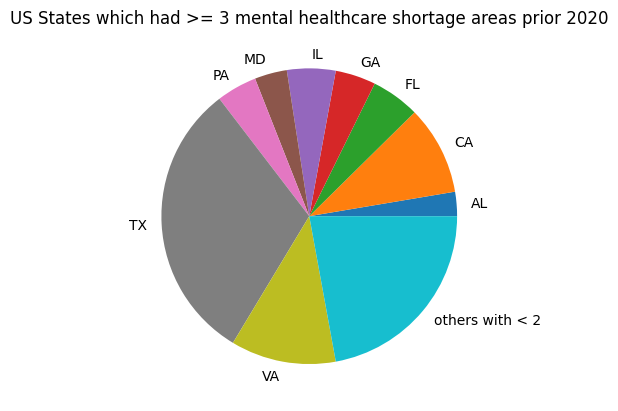

In [75]:
ndf=grouped_MHSA_df[['State_Abbr','number']].copy()
ndf['group']=[i for i in range(len(ndf))]
ndf['group']=ndf['group'].apply(lambda i: ndf['State_Abbr'][i] if ndf['number'][i] >= 3 else 'others with < 2'  )
ndfg=ndf.groupby('group').sum()
ax=plt.pie(ndfg['number'].values, labels=ndfg.index.values)
ax=plt.title('US States which had >= 3 mental healthcare shortage areas prior 2020' )

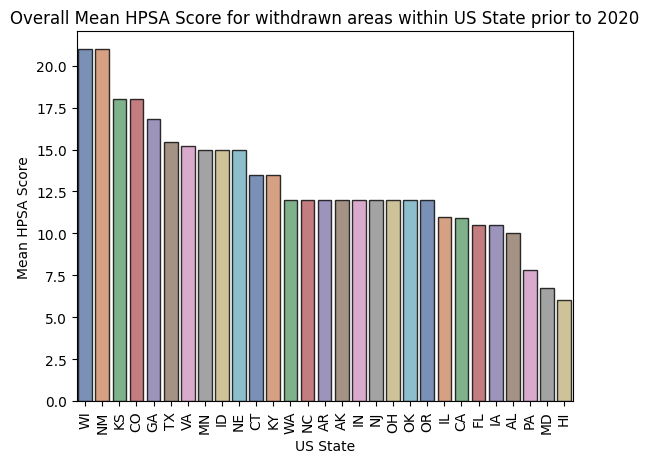

In [77]:
ndf=grouped_MHSA_df[['State_Abbr','averaged_HPSA_Score']].copy()
ax=sns.barplot(data=ndf.sort_values('averaged_HPSA_Score',ascending=False),x='State_Abbr',y='averaged_HPSA_Score',
               palette='deep',edgecolor='k',alpha=0.8)
ax=plt.xticks(rotation=90)
ax=plt.xlabel('US State')
ax=plt.ylabel('Mean HPSA Score')
ax=plt.title('Overall Mean HPSA Score for withdrawn areas within US State prior to 2020')

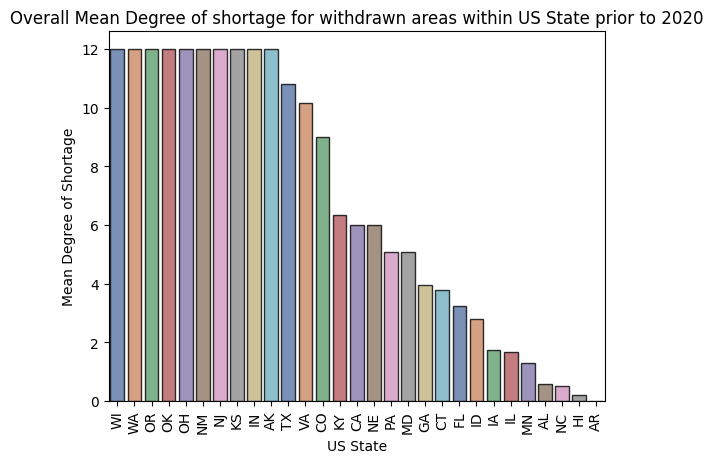

In [78]:
ndf=grouped_MHSA_df[['State_Abbr','averaged_Degree_of_Shortage']].copy()
ax=sns.barplot(data=ndf.sort_values('averaged_Degree_of_Shortage',ascending=False),x='State_Abbr',y='averaged_Degree_of_Shortage',
               palette='deep',edgecolor='k',alpha=0.8)
ax=plt.xticks(rotation=90)
ax=plt.xlabel('US State')
ax=plt.ylabel('Mean Degree of Shortage')
ax=plt.title('Overall Mean Degree of shortage for withdrawn areas within US State prior to 2020')

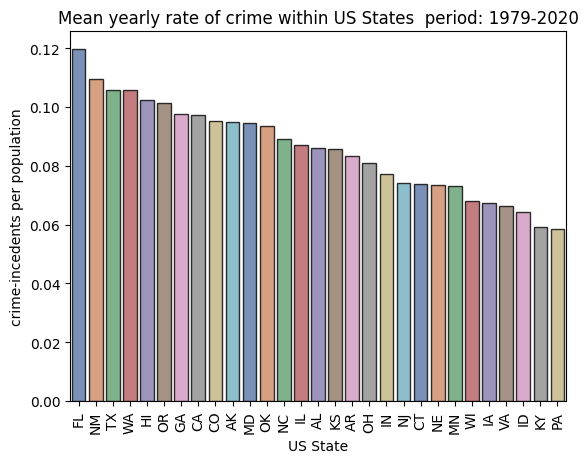

In [19]:
# sns.lineplot(data=est_crime_tot_all_states, x='year',y='WI')
dfn=est_crime_tot_all_states.drop('year',axis=1).mean()
dfn=dfn.sort_values(ascending=False)
mean_crime=dfn.copy()
ax=sns.barplot(x=dfn.index.values,y=dfn,
               palette='deep',edgecolor='k',alpha=0.8)
ax=plt.xticks(rotation=90)
ax=plt.xlabel('US State')
ax=plt.ylabel('crime-incedents per population')
ax=plt.title('Mean yearly rate of crime within US States  period: 1979-2020')

#dfn.index
## overall crime-rates in decending order period: 1979-2020
Index(['FL', 'NM', 'TX', 'WA', 'HI', 'OR', 'GA', 'CA', 'CO', 'AK', 'MD', 'OK',
       'NC', 'IL', 'AL', 'KS', 'AR', 'OH', 'IN', 'NJ', 'CT', 'NE', 'MN', 'WI',
       'IA', 'VA', 'ID', 'KY', 'PA'],
      dtype='object')

The pearson coef. between Crime-rate and MHSA Degree of Shortage averages for state data was 0.124
The pearson coef. between Crime-rate and MHSA HPSA Score averages for state data was -0.055


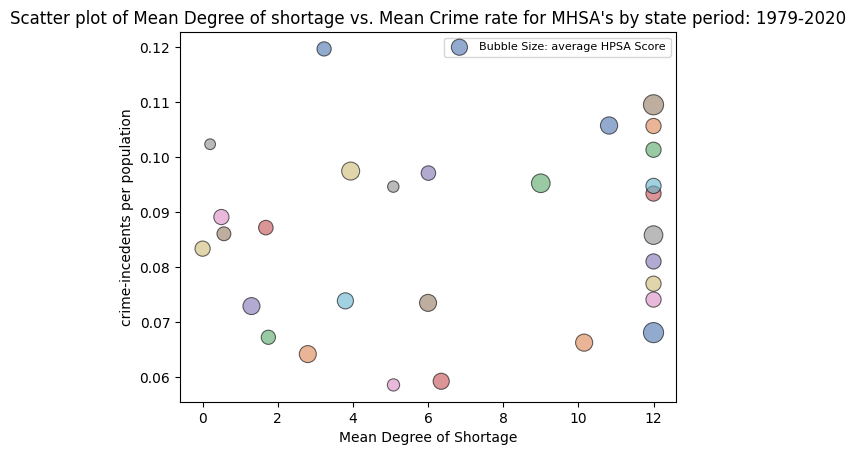

In [102]:
# put a scatter plot of average crime vs. degree of shortage. sizes are use bubble plot and 
# if time try to label in all the states - less nessasary 
# There may be a better way to do this 
# print(est_crime_tot_all_states.columns)
# grouped_MHSA_df['State_Abbr'].values
dfn=est_crime_tot_all_states.drop('year',axis=1).mean()
ax=sns.scatterplot(x=grouped_MHSA_df['averaged_Degree_of_Shortage'].values,y=dfn.values,alpha=0.6, edgecolor='k',palette='deep',
                s=10*grouped_MHSA_df['averaged_HPSA_Score'].values,hue=grouped_MHSA_df['State_Abbr'].values)
ax=plt.ylabel('crime-incedents per population')
ax=plt.xlabel('Mean Degree of Shortage')
ax=plt.title('Scatter plot of Mean Degree of shortage vs. Mean Crime rate for MHSA\'s by state period: 1979-2020')
ax=plt.legend(['Bubble Size: average HPSA Score'],fontsize="8")
# There is a weak correlation between crime and averaged_Degree_of_Shortage
# There is no correlation with HPSA Score 
mycorr1=np.corrcoef(grouped_MHSA_df['averaged_Degree_of_Shortage'].values,dfn.values)[0,1]
mycorr2=np.corrcoef(grouped_MHSA_df['averaged_HPSA_Score'].values,dfn.values)[0,1]
print("The pearson coef. between Crime-rate and MHSA Degree of Shortage averages for state data was %0.3f"%mycorr1 )
print("The pearson coef. between Crime-rate and MHSA HPSA Score averages for state data was %0.3f"%mycorr2 )

### There is clearly no relation between these Crime rates and the HPSA descriptors (Degree of Shortage, HPSA Score)

## Results of the T-testing for before and after groups:
The bar charts have two cols for each state A:'before' B:'after'

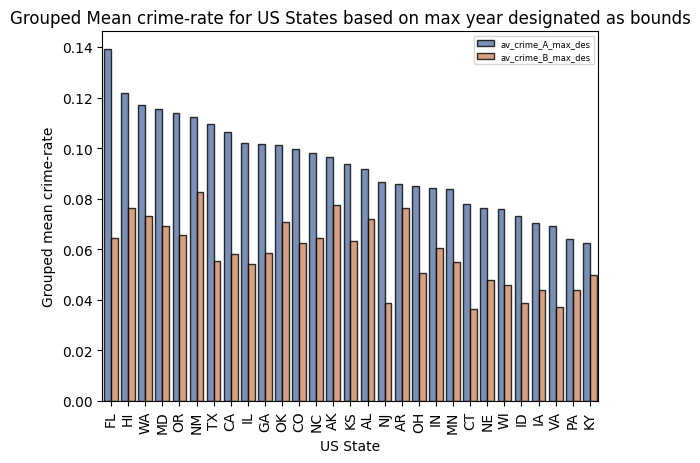

In [104]:
dfn=pd.melt(grouped_MHSA_df[['State_Abbr','av_crime_A_max_des','av_crime_B_max_des']],id_vars=['State_Abbr'], 
                   value_vars=['av_crime_A_max_des', 'av_crime_B_max_des'])
ax=sns.barplot(data=dfn.sort_values('value',ascending=False), x='State_Abbr', y='value', hue='variable',palette='deep',edgecolor='k',alpha=0.8)
ax=plt.xticks(rotation=90)
ax=plt.legend(fontsize="6")
ax=plt.xlabel('US State')
ax=plt.ylabel('Grouped mean crime-rate')
ax=plt.title('Grouped Mean crime-rate for US States based on max year designated as bounds')

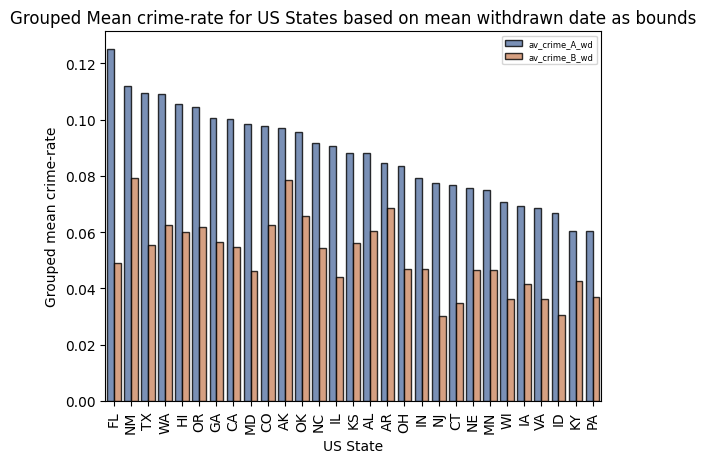

In [105]:
dfn=pd.melt(grouped_MHSA_df[['State_Abbr','av_crime_A_wd','av_crime_B_wd']],id_vars=['State_Abbr'], value_vars=['av_crime_A_wd', 'av_crime_B_wd'])
ax=sns.barplot(data=dfn.sort_values('value',ascending=False), x='State_Abbr', y='value', hue='variable',palette='deep',edgecolor='k',alpha=0.8)
ax=plt.xticks(rotation=90)
ax=plt.legend(fontsize="6")
ax=plt.xlabel('US State')
ax=plt.ylabel('Grouped mean crime-rate')
ax=plt.title('Grouped Mean crime-rate for US States based on mean withdrawn date as bounds')

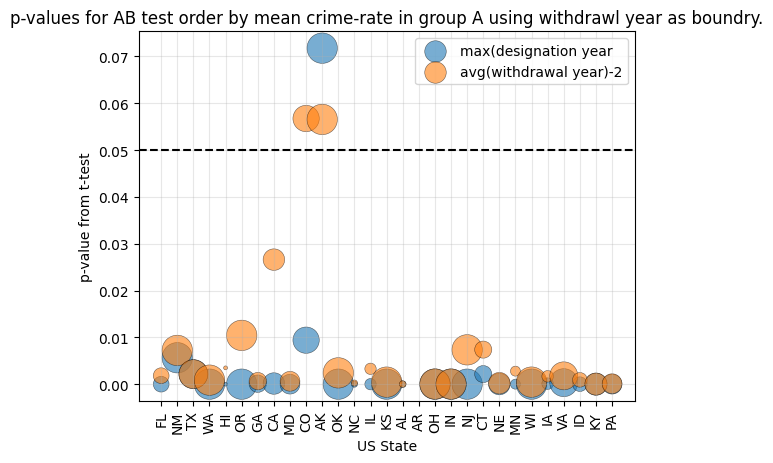

In [106]:
test2=grouped_MHSA_df.sort_values('av_crime_A_wd',ascending=False)
ax=sns.scatterplot(data=test2, x='State_Abbr', y='pvals_max_des_date', alpha=0.6, edgecolor='k',
                   s=40*test2['averaged_Degree_of_Shortage'].values.astype(float), label='max(designation year')
ax=sns.scatterplot(data=test2, x='State_Abbr', y='pvals_ave_withdraw_date', alpha=0.6, edgecolor='k',
                   s=40*test2['averaged_Degree_of_Shortage'].values.astype(float), label='avg(withdrawal year)-2')
ax=plt.grid(alpha=0.3)
ax=plt.axhline(0.05,c='k',linestyle='--')
ax=plt.xticks(rotation=90)
ax=plt.legend(loc=1)
ax=plt.xlabel('US State')
ax=plt.ylabel('p-value from t-test')
ax=plt.title('p-values for AB test order by mean crime-rate in group A using withdrawl year as boundry.')


#### The analytics are suggesting that the crime rates have diminished and $H_0$ can be rejected.
#### However in this case the $H_0$ is simply that there was no differnce in mean crime rate before or after the specified date. The correspondance with MHSA remains unclear. We have yet to prove a relationship between crime and MHSA and this will require futher digging. i.e.  National Incident Based Reporting System (NIBRS) data as opposed to Summary Reporting System (SRS) data.

### Use follium to pin-point the 113 MHSA locations on a map (add heat-mapping based on 'degree of shortage' parameter, also tooltip some of our stats)  

In [20]:
# Mapping of relevant data 

import folium
from folium.plugins import HeatMap

usa_map = folium.Map(location=[mh.latitude.mean(), mh.longitude.mean()], zoom_start=5,control_scale=True)

lats_longs_score = mh.loc[:,['latitude', 'longitude','HPSA_Score']].values
lats_longs_score[:,2]=lats_longs_score[:,2]*10 # rewieght
# lats_longs_score
HeatMap(list(lats_longs_score) ,radius=20,blur=20,name='HPSA_Score').add_to(usa_map)
folium.LayerControl().add_to(usa_map)

for idx in range(len(mh)):
    location = [mh.iloc[idx,:].latitude, mh.iloc[idx,:].longitude]
    us_state=mh.iloc[idx,:].State_Abbr
    city=mh.iloc[idx,:].City
    county=mh.iloc[idx,:].County_Name
    dos=float(mh.iloc[idx,:].Degree_of_Shortage)
    mean_CR=mean_crime[us_state]
    folium.Marker(location = location, popup = '%s, %s, %s, state_crime:%.3f, degree:%.3f'%(us_state,city,county,mean_CR,dos) ).add_to(usa_map)                                                     
    folium.Circle(radius=20000,location=location,color='blue',fill=False,).add_to(usa_map) # the radius is in meters so this is a 20km radius

usa_map

In [21]:
usa_map.save("MHSA_shortlisted.html")

#dfn.index
## overall crime-rates in decending order period: 1979-2020
Index(['FL', 'NM', 'TX', 'WA', 'HI', 'OR', 'GA', 'CA', 'CO', 'AK', 'MD', 'OK',
       'NC', 'IL', 'AL', 'KS', 'AR', 'OH', 'IN', 'NJ', 'CT', 'NE', 'MN', 'WI',
       'IA', 'VA', 'ID', 'KY', 'PA'],
      dtype='object')

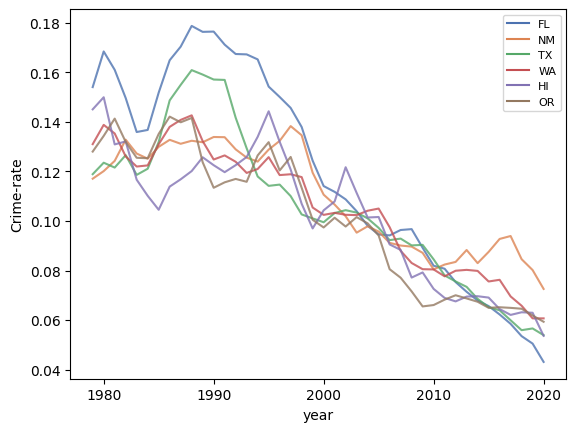

In [110]:

dfn=pd.melt(est_crime_tot_all_states[['year','FL','NM','TX', 'WA', 'HI', 'OR']], id_vars=['year'], value_vars=['FL','NM','TX', 'WA', 'HI', 'OR']) 
dfn.columns=['year','State','Crime-rate']
ax=sns.lineplot(data=dfn,x='year',y='Crime-rate',hue='State', palette='deep',alpha=0.8)
ax=plt.legend(fontsize="8")

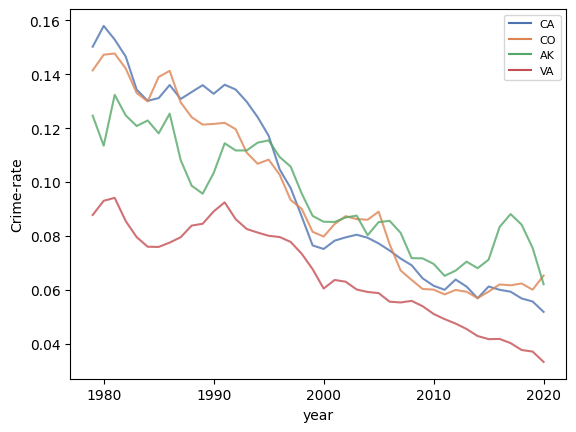

In [111]:

dfn=pd.melt(est_crime_tot_all_states[['year','CA','CO','AK','VA']], id_vars=['year'], value_vars=['year','CA','CO','AK','VA']) 
dfn.columns=['year','State','Crime-rate']
ax=sns.lineplot(data=dfn,x='year',y='Crime-rate',hue='State', palette='deep',alpha=0.8)
ax=plt.legend(fontsize="8")

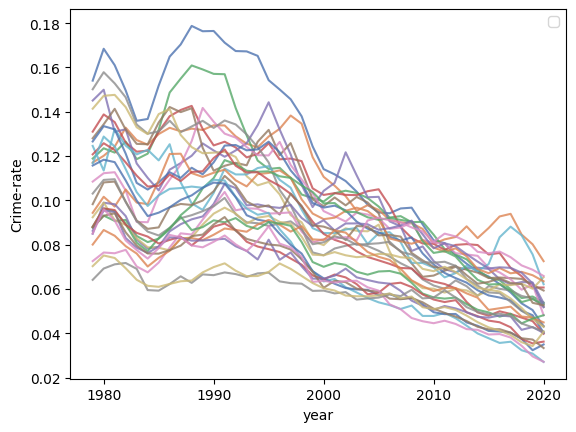

In [112]:

dfn=pd.melt(est_crime_tot_all_states[['year','FL', 'NM', 'TX', 'WA', 'HI', 'OR', 'GA', 'CA', 'CO', 'AK', 'MD', 'OK', 'NC', 'IL', 'AL', 'KS', 'AR', 'OH', 'IN', 'NJ', 'CT', 'NE', 'MN', 'WI', 'IA', 'VA', 'ID', 'KY', 'PA']], 
               id_vars=['year'], value_vars=['FL', 'NM', 'TX', 'WA', 'HI', 'OR', 'GA', 'CA', 'CO', 'AK', 'MD', 'OK', 'NC', 'IL', 'AL', 'KS', 'AR', 'OH', 'IN', 'NJ', 'CT', 'NE', 'MN', 'WI', 'IA', 'VA', 'ID', 'KY', 'PA']) 
dfn.columns=['year','State','Crime-rate']
ax=sns.lineplot(data=dfn,x='year',y='Crime-rate',hue='State', palette='deep',alpha=0.8)
ax=plt.legend('')

### There is clearly an overall decrease in crime over the last 30 years for all states based on SRS data. Any number of factors might have been responsible for this observed reduction in crime. 
#### In order to better identify any relation with MHSA, we must dive into this further. For each of the 113 MHSA locations listed we can use the FBI API 'arrests' function to identify nearby FBI agencies which have reported National Incident Based Reporting System (NIBRS) data.


### define helper functions to search for nearby agencies based on MHSA location.

In [137]:
def get_agencies(us_state,city,county,location):
    '''
    input the state, city, county and geo-coords
    '''
    baseurl = "https://api.usa.gov/crime/fbi/cde"
    API_KEY = {"API_KEY":"8rM3xn6vwWG6FEJCYYtgY2XKh8Kl47N08gx5ERx1"}
    urlvar="/agency/byStateAbbr/%s"%(us_state)   # agencys in Calaforia
    response = requests.request("GET", baseurl+urlvar, params=API_KEY)
    agency=response.json()
    df_agency=pd.DataFrame(agency)
    return df_agency

In [138]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the distance between two points on the Earth's surface using the Haversine formula.
    """
    R = 6371  # Earth's radius in kilometers
    
    # convert latitudes and longitudes to radians
    lon1, lat1, lon2, lat2 = np.radians([lon1, lat1, lon2, lat2])
    
    # calculate differences in latitudes and longitudes
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # apply Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    
    return distance

### Define a function we can use at a later stage to grab the NIBRS arrest data from a specific agency within a particular time period (saves the data as .json)

In [139]:
def get_arrests(ori,year_from,year_to,idx):
    '''
     This function takes in the ori agency code and desired years for which 
     data will be extracted. If data is present tt will save the data in .json 
     for further processing. Provides error message if there was no data. 
    '''
    baseurl = "https://api.usa.gov/crime/fbi/cde"
    urlvar="/arrest/agency/%s/all"%(ori)   # arrest info from this agency in CA
    API_KEY = {"API_KEY":"8rM3xn6vwWG6FEJCYYtgY2XKh8Kl47N08gx5ERx1"}
    date_from_to = {'from':year_from,'to':year_to}
    api_params = dict(**API_KEY,**date_from_to)    # here I am using the unpacking operator ** to merge dictionaries 
    response = requests.request("GET", baseurl+urlvar, params=api_params)
    arrests=response.json()
    df_arr=pd.DataFrame(arrests['data'])
    
    if len(df_arr) == 0 : 
        print("There was no avaliable crime data for the folowing agency !!!")
        fr_year=0
        to_year=0
        filename='none'
    else:
        fr_year=df_arr['data_year'].iloc[0]
        to_year=df_arr['data_year'].iloc[-1]
        print("data from %s actually in the range %i - %i"%(ori,fr_year,to_year))
        filename=('%s_%s_%s_%i.json'%(ori,fr_year,to_year,idx))
        with open('./data/%s'%filename, 'w') as file:
            json.dump(arrests, file)
            
    return df_arr,filename,int(fr_year),int(to_year)

# Below is the code used to create a master hit list of agencies with possible NIBRS crime data that correspond with MHSA locations 

In [141]:
# This takes a while - run already
agency_min_radius=0.03
# for idx in range(6):
for idx in mh.index:
    location = [mh.iloc[idx,:].latitude, mh.iloc[idx,:].longitude]
    us_state=mh.iloc[idx,:].State_Abbr
    city=mh.iloc[idx,:].City
    county=mh.iloc[idx,:].County_Name
    df_agency=get_agencies(us_state,city,county,location)
    coords=(df_agency[['latitude','longitude']].values).astype(float)
    arr=np.c_[np.zeros((len(coords),2))+location,coords]
    distances=haversine(arr[:,0],arr[:,1],arr[:,2],arr[:,3])
    L2=sum((coords-location)**2,axis=1)
    mindist=min(distances)
    minL2=min(L2)
    df_agency['distance_from_shortage']=distances
    df_agency['L2']=L2
    if minL2 > agency_min_radius  : 
        print("warning minimum L2: increase radius ",minL2," searching with larger radius ",minL2+agency_min_radius)
        hits=df_agency[df_agency['L2'] <= (minL2+agency_min_radius)]
    else:
        hits=df_agency[df_agency['L2'] <= agency_min_radius]
    hits.insert(0,'MHSA_idx',[idx]*len(hits))   # this col allows indexing with the MHSA shortlist table
    print(minL2,len(hits))
    master_hitlist_df=pd.concat([master_hitlist_df,hits],axis=0)
   # .insert(2, 'Places', places) 
## need to concat these sub hitlists into a master hit list 

7.599789507998845e-05 3
0.009574488324999861 6
0.009809399476065683 3
0.02537203770807569 11
0.005239398291373396 6
0.004052201864721868 11
0.00486718116198726 11
warning minimum L2: increase radius  0.04516582584146656  searching with larger radius  0.07516582584146655
0.04516582584146656 8
0.02030407351834966 2
1.1639560213304794e-05 27
0.0013883179045971984 2
0.01450042164818006 1
0.0008751026315861343 5
0.00011435362238893811 5
0.007248464729999431 2
0.005395748344558485 1
warning minimum L2: increase radius  0.04326378924928411  searching with larger radius  0.07326378924928412
0.04326378924928411 3
warning minimum L2: increase radius  0.033973873110363186  searching with larger radius  0.06397387311036318
0.033973873110363186 4
warning minimum L2: increase radius  0.031073391261546422  searching with larger radius  0.06107339126154642
0.031073391261546422 16
0.001021628220310028 4
7.448563549004729e-05 4
0.010169161048990375 3
0.0008489911791925444 4
9.345425000034961e-07 18
1.97

In [144]:
# How many agencies 
len(master_hitlist_df)

769

In [145]:
master_hitlist_df.head()

,MHSA_idx,ori,agency_name,state_name,state_abbr,division_name,region_name,region_desc,county_name,agency_type_name,nibrs,nibrs_start_date,latitude,longitude,distance_from_shortage,L2
140,0,CA0150900,Tehachapi Police Department,California,CA,Pacific,West,Region IV,KERN,City,False,None,35.13094,-118.447235,14.110740,0.016124
142,0,CA0151400,Stallion Springs Police Department,California,CA,Pacific,West,Region IV,KERN,City,False,None,35.082546,-118.63749,7.414964,0.005893
143,0,CA0151500,Bear Valley Police Department,California,CA,Pacific,West,Region IV,KERN,City,False,None,35.134567,-118.574615,0.466231,0.000076
426,1,CA033790X,Eastvale Police Department,California,CA,Pacific,West,Region IV,RIVERSIDE,City,False,None,34.01191,-117.448814,14.808889,0.022872
428,1,CA0339900,Highway Patrol: Riverside County,California,CA,Pacific,West,Region IV,RIVERSIDE,State Police,False,None,33.92241,-117.410866,18.440534,0.027562


In [5]:
# load csv
master_hitlist_df=pd.read_csv('./tableau_datafiles/agency_hitlist.csv')

In [6]:
master_hitlist_df.iloc[0]

MHSA_idx                                            0
ori                                         CA0150900
agency_name               Tehachapi Police Department
state_name                                 California
state_abbr                                         CA
division_name                                 Pacific
region_name                                      West
region_desc                                 Region IV
county_name                                      KERN
agency_type_name                                 City
nibrs                                           False
nibrs_start_date                                  NaN
latitude                                     35.13094
longitude                                 -118.447235
distance_from_shortage                       14.11074
L2                                           0.016124
Name: 0, dtype: object

In [146]:
query = """

SELECT MHSA_idx, state_name , count(1) as agencies_within_max_distance, 
       AVG(distance_from_shortage) as avergae_distance_from_shortage,
       MAX(distance_from_shortage) as max_distance_from_shortage, 
       MIN(distance_from_shortage) as min_distance_from_shortage 
       FROM agency_hitlist 
       group by MHSA_idx, state_name
ORDER BY agencies_within_max_distance DESC
;
        """
myquery = sql.read_sql(query, con=conn)
myquery

,MHSA_idx,state_name,agencies_within_max_distance,avergae_distance_from_shortage,max_distance_from_shortage,min_distance_from_shortage
0,37,California,73,8.491146,18.101224,4.401829
1,106,Pennsylvania,48,6.192223,15.098272,0.601780
2,79,Pennsylvania,38,6.415865,15.977019,0.264366
3,9,Texas,27,5.890362,17.648267,0.262612
4,69,Texas,26,5.593958,17.045657,0.204564
...,...,...,...,...,...,...
108,51,Texas,1,8.531235,8.531235,8.531235
109,77,Virginia,1,15.710909,15.710909,15.710909
110,84,California,1,1.890142,1.890142,1.890142
111,103,Iowa,1,3.538611,3.538611,3.538611


#### We will grab the arrest data and save details in seperate .json files 
#### Before setting up the arrest data lets make a more detailed map which shows all the 769 agencies reletive to the 113 MHSAs

In [22]:
# Mapping of relevant data 
# here the heat map is less useful and we just want to show agency data

usa_map = folium.Map(location=[mh.latitude.mean(), mh.longitude.mean()], zoom_start=5,control_scale=True)

lats_longs_score = mh.loc[:,['latitude', 'longitude','HPSA_Score']].values
lats_longs_score[:,2]=lats_longs_score[:,2]*10 # rewieght
# lats_longs_score
# HeatMap(list(lats_longs_score) ,radius=20,blur=20,name='HPSA_Score').add_to(usa_map)
# folium.LayerControl().add_to(usa_map)

for idx in range(len(mh)):
    location = [mh.iloc[idx,:].latitude, mh.iloc[idx,:].longitude]
    us_state=mh.iloc[idx,:].State_Abbr
    city=mh.iloc[idx,:].City
    county=mh.iloc[idx,:].County_Name
   #  folium.Marker(location = location, popup = 'HPSA_Shortage_location \n %s \n %s \n %s'%(us_state,city,county) ).add_to(usa_map)                                                     
    folium.Circle(radius=20000,location=location,color='blue',fill=False,).add_to(usa_map) # the radius is in meters so this is a 20km radius
    dos=float(mh.iloc[idx,:].Degree_of_Shortage)
    mean_CR=mean_crime[us_state]
    folium.Marker(location = location, popup = '%s, %s, %s, state_crime:%.3f, degree:%.3f'%(us_state,city,county,mean_CR,dos) ).add_to(usa_map)  

for index, row in master_hitlist_df.iterrows():
    location = [row.latitude, row.longitude]
    folium.Marker(location = location, icon=folium.Icon(icon='fa-star',prefix='fa',color='red'), popup = 'agency:' +str(row.agency_name)).add_to(usa_map)

usa_map 

In [23]:
# should have saved the map as html
usa_map.save("MHSA_and_nearby_NIBRS.html")

#### Create a table in our sqlite3 db to store some on-the-fly supplement data 

#### Below is the code that runs the get_arrests(ori,year_from,year_to,MHSA_idx) function for each of the 769 agencies
#### This creates 769 .json files saved locally (eg. ./data/CA0139900_2000_2020_16.json) and adds relevant entries to the sqlite3 agency_data_extraction_sup_info table
#### I have turned this off now becasue it take a while to run 

# now read in .json based on which state we are interested in and do some EDA as well as T-test if possible


## overall crime-rates in decending order period: 1979-2020
Index(['FL', 'NM', 'TX', 'WA', 'HI', 'OR', 'GA', 'CA', 'CO', 'AK', 'MD', 'OK',
       'NC', 'IL', 'AL', 'KS', 'AR', 'OH', 'IN', 'NJ', 'CT', 'NE', 'MN', 'WI',
       'IA', 'VA', 'ID', 'KY', 'PA'],
      dtype='object')
      
# setup so we can do plots and t-test on-demand for each state

In [149]:
# this is so we can look at the MHSA data grouped by state
grouped_HPSA=pd.read_csv('./data/grouped_HPSA_usa_states_info.csv')
grouped_HPSA.head()

,State_Abbr,number,averaged_Degree_of_Shortage,averaged_HPSA_Score,MIN(Designation_Date),MAX(Designation_Date),AVG(Designation_Date),MIN(HPSA_Withdrawn_Date),MAX(HPSA_Withdrawn_Date),AVG(HPSA_Withdrawn_Date),bnd_max_desig_year,bnd_avg_withdr_year,pvals_max_des_date,av_crime_A_max_des,av_crime_B_max_des,av_crime_A_wd,av_crime_B_wd,pvals_ave_withdraw_date
0,WI,1,12.0,21.0,2009-11-18,2009-11-18,2009.0,2019-06-25,2019-06-25,2019.0,2009,2017,1.019227e-09,0.076015,0.045856,0.070555,0.036412,0.000440
1,WA,1,12.0,12.0,2009-11-18,2009-11-18,2009.0,2019-06-25,2019-06-25,2019.0,2009,2017,3.483573e-10,0.117142,0.073348,0.109001,0.062402,0.000861
2,OR,1,12.0,12.0,2009-11-18,2009-11-18,2009.0,2019-06-25,2019-06-25,2019.0,2009,2017,4.505153e-09,0.114047,0.065583,0.104387,0.061927,0.010423
3,OK,2,12.0,12.0,2009-11-18,2009-11-18,2009.0,2019-06-25,2019-06-25,2019.0,2009,2017,1.752399e-10,0.101400,0.070822,0.095511,0.065833,0.002413
4,OH,1,12.0,12.0,2015-10-05,2015-10-05,2015.0,2019-06-25,2019-06-25,2019.0,2015,2017,2.070388e-07,0.085171,0.050588,0.083684,0.046871,0.000032


### Input the state we want to focus on and run a SQL query to get  MHSA_idx and number_of_agencies from the previously saved agency_hitlist 

In [297]:
focus_state='TX'
query = """
SELECT MHSA_idx, count(1) as number_of_agencies
FROM agency_hitlist  
WHERE state_abbr = '%s' 
GROUP BY MHSA_idx;
"""
grouped_MHSA_ids = sql.read_sql(query%(focus_state), con=conn)
grouped_MHSA_ids 


,MHSA_idx,number_of_agencies
0,5,11
1,6,11
2,7,8
3,8,2
4,9,27
5,38,5
6,39,2
7,40,7
8,41,2
9,42,4


In [298]:
# get the list of MHSA IDs to iterate over
my_mhsa_ids=list(grouped_MHSA_ids['MHSA_idx'].values)
num_agencies=grouped_MHSA_ids['number_of_agencies'].sum()
print("MHSA IDs for the state of %s with total of %i agencies"%(focus_state,num_agencies), my_mhsa_ids)


MHSA IDs for the state of TX with total of 201 agencies [5, 6, 7, 8, 9, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 69, 100]


### This is just an optional query to create a listing of the agencies next to any specific MHSA. For each state there are multiple MHSAs and we can pick one MHSA ID to take a look at the nearby agencies

In [274]:
mhsa_id = 16
    
print("working on MHSA ID %i"%mhsa_id)
query = """
    SELECT * FROM agency_data_extraction_sup_info
     WHERE mhsa_id = %i;
        """
agency_sup_info = sql.read_sql(query%(mhsa_id), con=conn)
agency_sup_info

working on MHSA ID 16


,id,mhsa_id,agency_ori,agency_name,designate_year,withdrawn_year,data_from_year,data_to_year,filename
0,105,16,CA0130400,El Centro Police Department,2000,2019,2000,2020,CA0130400_2000_2020_16.json
1,106,16,CA0130600,Imperial Police Department,2000,2019,2000,2020,CA0130600_2000_2020_16.json
2,107,16,CA0139900,Highway Patrol: Imperial County,2000,2019,2000,2020,CA0139900_2000_2020_16.json


#### Iterate through all the relevant data (*.json). Munge and pool the crime data, then save the results as a list of dictionaries. Each dictionary corresponds to a MHSA entry from our initial shortlist. Also perform a T-test for the AB grouping of data from each agency. Here $H_0$ is closer to our intended more general $H_0$: "that there is no relationship between any shortage of mental health services and the incidence of crime."
#### Specifically, this t-test has $H_0$: "that there is no difference in means for an NIBRS agency crime data near an MHSA location before and after the date the MHSA status had been withdrawn.

#### Note: The search period was defined by the availability of data. We input a request for a specific time period that is based on the MHSA designation date and withdrawal date. We ask the NIBRS agency to give us as much data for this time period as possible, but often there are null entries, which we have cleaned as best as possible. Crime counts are summed as part of the workflow. 

In [299]:
'''
go through all the saveed .json munge and pool the crime data 
save as list of dictionaries. each dict corresponds to an MHSA row from our intital shortlist
also calculate p-Value from t-test 
'''

# my_mhsa_ids=[110]
agency_grouped_crime_data=[]
# for idx in range(len(mh)):
# for idx in range(10):
for idx in my_mhsa_ids :
    mhsa_id = idx
    
    print("working on MHSA ID %i"%mhsa_id)
    query = """
    SELECT * FROM agency_data_extraction_sup_info
     WHERE mhsa_id = %i;
        """
    agency_sup_info = sql.read_sql(query%(mhsa_id), con=conn)
    
   # ref_from_year=agency_sup_info.data_from_year.max()
   # ref_to_year=agency_sup_info.data_to_year.min()
   # withdrawn_year=agency_sup_info.withdrawn_year.min()
   # print(ref_from_year,ref_to_year,withdrawn_year)

    agencies=[]
    crime_tots=pd.DataFrame()  # create a fresh data frame 
    for agency in agency_sup_info.iterrows():
        ref_from_year=agency[1].data_from_year
        ref_to_year=agency[1].data_to_year
        withdrawn_year=agency[1].withdrawn_year
        filename=agency[1].filename
        agency_name=agency[1].agency_name
        agencies.append(agency_name)
        if filename != 'none':
            
            with open('./data/%s'%filename, 'r') as file:
                agency_crime = json.load(file)
            agency_crime_df=pd.DataFrame(agency_crime['data'])
            agency_crime_df['tot_crime'] = agency_crime_df.drop(['data_year'],axis=1).astype(int).sum(axis=1)
            df_slice=agency_crime_df[(agency_crime_df['data_year']>=ref_from_year)  & (agency_crime_df['data_year']<=ref_to_year)]
            crime_tots=pd.concat([crime_tots,df_slice[['data_year','tot_crime']]],axis=0)
            data_years=df_slice.data_year.values
            #. we are going to assume empty when data for the year is empty the crime count was 0. needs revision later      
            
            
            
        else:
            print ( "%s has no data avaliable" %agency_name)
 
    if len(crime_tots) != 0 :
        grouped_crime_tots = crime_tots.groupby('data_year').sum()  #. this is the collective info we want - this gets around the problem of empty data entries 

        if withdrawn_year <= grouped_crime_tots.index.max():
        
            group_a=grouped_crime_tots[grouped_crime_tots.index.values<withdrawn_year].tot_crime.values
            group_b=grouped_crime_tots[grouped_crime_tots.index.values>=withdrawn_year].tot_crime.values
 
            if group_a.size > 0: 
                ave_counts_group_a=int(np.mean(group_a))
            else:
                ave_counts_group_a=0

            if group_b.size >0: 
                ave_counts_group_b=int(np.mean(group_b))
            else:
                ave_counts_group_b=0
                
            t_statistic, p_value = stats.ttest_ind(group_a, group_b)
        
        mydict= {'mhsa_id': mhsa_id,
              'agencies':agencies,
             'withdrawn_year': withdrawn_year,
            'ave_counts_group_a': ave_counts_group_a,
            'ave_counts_group_b': ave_counts_group_b,
                 'p-value': p_value,
            'data_year' : list(grouped_crime_tots.index.values) , 
            'tot_crime' : list(grouped_crime_tots.tot_crime.values)}
    
    else:
        mydict= {'mhsa_id': mhsa_id,
              'agencies':agencies,
             'withdrawn_year': withdrawn_year,
                  'ave_counts_group_a': None,
            'ave_counts_group_b': None,
                 'p-value': None, 
            'data_year' : list([]) , 
            'tot_crime' : list([])}
    


    

    agency_grouped_crime_data.append(mydict)

working on MHSA ID 5
Kendleton Police Department has no data avaliable
working on MHSA ID 6
Kendleton Police Department has no data avaliable
working on MHSA ID 7
working on MHSA ID 8
working on MHSA ID 9
working on MHSA ID 38
working on MHSA ID 39
working on MHSA ID 40
working on MHSA ID 41
working on MHSA ID 42
Trenton Police Department has no data avaliable
working on MHSA ID 43
working on MHSA ID 44
working on MHSA ID 45
working on MHSA ID 46
working on MHSA ID 47
working on MHSA ID 48
working on MHSA ID 49
working on MHSA ID 50
working on MHSA ID 51
working on MHSA ID 52
working on MHSA ID 53
working on MHSA ID 54
working on MHSA ID 55
Trenton Police Department has no data avaliable
working on MHSA ID 56
working on MHSA ID 57
working on MHSA ID 58
working on MHSA ID 59
working on MHSA ID 60
working on MHSA ID 61
working on MHSA ID 62
working on MHSA ID 63
working on MHSA ID 64
working on MHSA ID 65
Rose City Police Department has no data avaliable
working on MHSA ID 69
working on 

### Look at the entries in our listing for the focus state  

In [300]:
# agency_grouped_crime_data
# grouped_crime_tots
# crime_tots
agcd= pd.DataFrame(agency_grouped_crime_data)
agcd.head()

,mhsa_id,agencies,withdrawn_year,ave_counts_group_a,ave_counts_group_b,p-value,data_year,tot_crime
0,5,"[Fort Bend County Sheriff's Office, Missouri C...",2019,9162,6016,0.016953,"[2016, 2017, 2018, 2019, 2020, 2021]","[8486, 9959, 9043, 7323, 5082, 5644]"
1,6,"[Fort Bend County Sheriff's Office, Missouri C...",2019,9162,6016,0.016953,"[2016, 2017, 2018, 2019, 2020, 2021]","[8486, 9959, 9043, 7323, 5082, 5644]"
2,7,"[Gregg County Sheriff's Office, Gladewater Pol...",2019,5397,4855,0.284781,"[2016, 2017, 2018, 2019, 2020, 2021]","[5537, 5413, 5242, 5716, 4393, 4458]"
3,8,"[Walker County Sheriff's Office, Huntsville Po...",2019,3368,2368,0.056215,"[2016, 2017, 2018, 2019, 2020, 2021]","[3390, 3195, 3521, 3079, 2145, 1880]"
4,9,"[Harris County Sheriff's Office, Bellaire Poli...",2019,91470,62370,0.019761,"[2016, 2017, 2018, 2019, 2020, 2021]","[105543, 88758, 80111, 61423, 59420, 66269]"


### What was the average Withdrawn date for the focus state ?

In [277]:
int(grouped_HPSA[grouped_HPSA['State_Abbr']==focus_state]['AVG(HPSA_Withdrawn_Date)'].values[0])

2019

### Visualise the data and see the results of any T-tests.

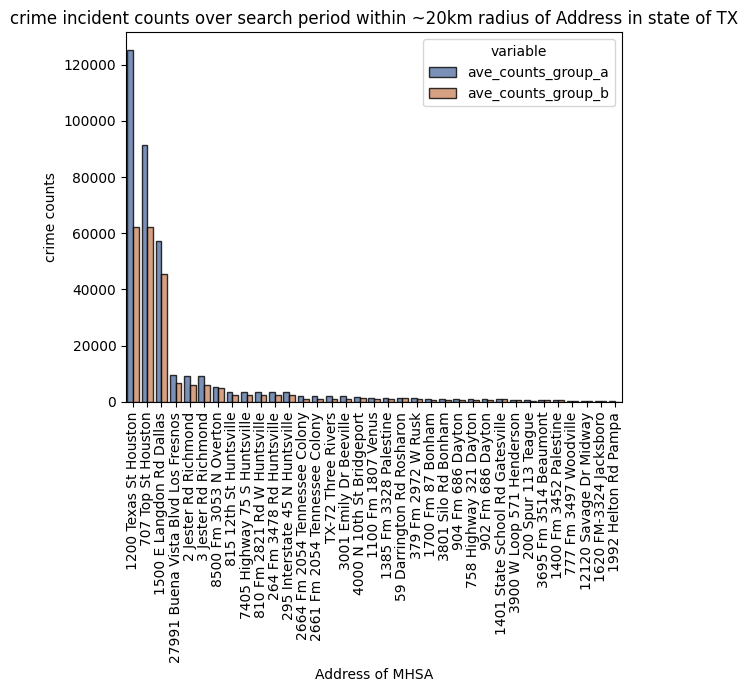

In [301]:
addresss =[mh.iloc[idx,:].Address+str(' ')+ mh.iloc[idx,:].City  for idx in my_mhsa_ids]

ndf=agcd[['ave_counts_group_a','ave_counts_group_b']].copy()
ndf['addres']=addresss

nndf=pd.melt(ndf, id_vars=['addres'], value_vars=['ave_counts_group_a','ave_counts_group_b'] )
ax=sns.barplot(data=nndf.sort_values('value',ascending=False),x='addres',y='value', hue='variable',palette='deep',edgecolor='k',alpha=0.8)
ax=plt.xticks(rotation=90)
ax=plt.xlabel('Address of MHSA')
ax=plt.ylabel('crime counts')
ax=plt.title('crime incident counts over search period within ~20km radius of Address in state of %s'%(focus_state))

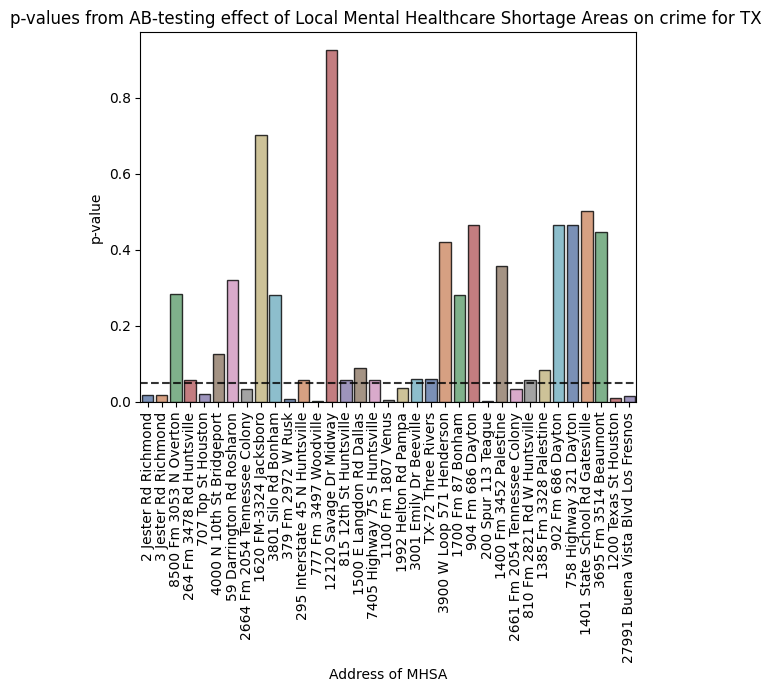

In [302]:
ax=sns.barplot(x=addresss,y=agcd['p-value'].values,palette='deep',edgecolor='k',alpha=0.8)
ax=plt.xticks(rotation=90)
ax=plt.axhline(0.05,linestyle='--',c='k',alpha=0.8)
ax=plt.title('p-values from AB-testing effect of Local Mental Healthcare Shortage Areas on crime for %s ' %(focus_state))
ax=plt.xlabel('Address of MHSA')
ax=plt.ylabel('p-value')

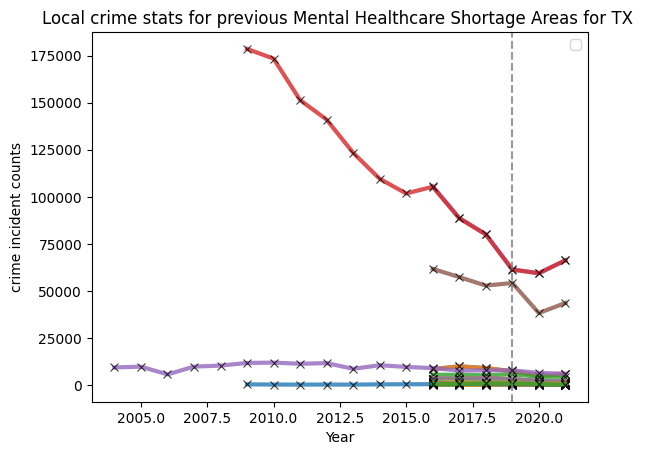

In [303]:
wd=int(grouped_HPSA[grouped_HPSA['State_Abbr']==focus_state]['AVG(HPSA_Withdrawn_Date)'].values[0])
for r in agcd.iterrows():
    mhsa_id=(r)[1].mhsa_id
    p_value=(r)[1]['p-value']
    data_year=(r)[1].data_year
    tot_crime=(r)[1].tot_crime
    address = mh.iloc[mhsa_id,:].Address 
    City = mh.iloc[mhsa_id,:].City
    dos = mh.iloc[mhsa_id,:].Degree_of_Shortage
    HPSA_Score = mh.iloc[mhsa_id,:].HPSA_Score
    ax=sns.lineplot(x=data_year,y=tot_crime,marker='x',markeredgecolor='k',linewidth=3,alpha=0.8,label='%s, %s, d:(%.2f, %i) p: %.3f'%(address,City,float(dos),HPSA_Score,p_value))
ax=plt.axvline(wd,linestyle='--',c='grey',alpha=0.8,label='mean year of withdrawal for all areas: %i'%wd)
ax=plt.title('Local crime stats for previous Mental Healthcare Shortage Areas for %s ' %(focus_state))
# ax=plt.legend(fontsize='8',loc=2)
ax=plt.legend('')
ax=plt.xlabel('Year')
ax=plt.ylabel('crime incident counts')

In [304]:
if np.any(agcd['p-value'].isnull()) : 
    print('certain p-values were not calculated for %s'%(focus_state))
    print(agcd['p-value'])
else: 
    proportion_pvalues_gt_alpha= sum(agcd['p-value']<0.05)/len(agcd)
    print("The percentage of p-values below alpha=0.05 for the state of %s was %.3f%%" %(focus_state,proportion_pvalues_gt_alpha*100))

The percentage of p-values below alpha=0.05 for the state of TX was 34.286%


### We will iterate on this for all the states of interest with MHSAs so as to make a more clear conclusion  

In [254]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [255]:
# placed functions in a seperate python script get_agency_data.py
# supressed some  printing 
from get_agency_data import get_agency_data 
from get_agency_data import get_mhsa_ids_for_state 

In [256]:
dfn=est_crime_tot_all_states.drop('year',axis=1).mean()
dfn=dfn.sort_values(ascending=False)
my_focus_states=dfn.index.values
# for focus_state in my_focus_states: print (type(focus_state))

In [269]:
# focus_state='CA'
pvalue_percent_per_state=[]
for focus_state in my_focus_states:
    my_mhsa_ids,num_agencies=get_mhsa_ids_for_state(focus_state)
    print("MHSA IDs for the state of %s with total of %i agencies"%(focus_state,num_agencies), my_mhsa_ids)
    agcd=get_agency_data(my_mhsa_ids)
    if np.any(agcd['p-value'].isnull()) : 
        print('certain p-values were not calculated for %s'%(focus_state))
        print(agcd['p-value'])
        proportion_pvalues_gt_alpha=0.0
    else: 
        proportion_pvalues_gt_alpha= sum(agcd['p-value']<0.05)/len(agcd)
        print("The percentage of p-values below alpha=0.05 for the state of %s was %.3f%%" %(focus_state,proportion_pvalues_gt_alpha*100))
    pvalue_percent_per_state.append(proportion_pvalues_gt_alpha)

MHSA IDs for the state of FL with total of 39 agencies [18, 34, 87, 90, 91, 94]
certain p-values were not calculated for FL
0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
5    0.160843
Name: p-value, dtype: float64


/Users/echanj/.local/share/virtualenvs/jupyter_stuff-JQ3hnF7h/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/echanj/.local/share/virtualenvs/jupyter_stuff-JQ3hnF7h/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MHSA IDs for the state of NM with total of 2 agencies [68]
certain p-values were not calculated for NM
0   NaN
Name: p-value, dtype: float64
MHSA IDs for the state of TX with total of 201 agencies [5, 6, 7, 8, 9, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 69, 100]
The percentage of p-values below alpha=0.05 for the state of TX was 34.286%
MHSA IDs for the state of WA with total of 7 agencies [28]
The percentage of p-values below alpha=0.05 for the state of WA was 0.000%
MHSA IDs for the state of HI with total of 1 agencies [108]
The percentage of p-values below alpha=0.05 for the state of HI was 100.000%
MHSA IDs for the state of OR with total of 6 agencies [29]
The percentage of p-values below alpha=0.05 for the state of OR was 0.000%
MHSA IDs for the state of GA with total of 29 agencies [4, 33, 93, 98, 105]
The percentage of p-values below alpha=0.05 for the state of GA was 80.000%
MHSA IDs for the state of CA with

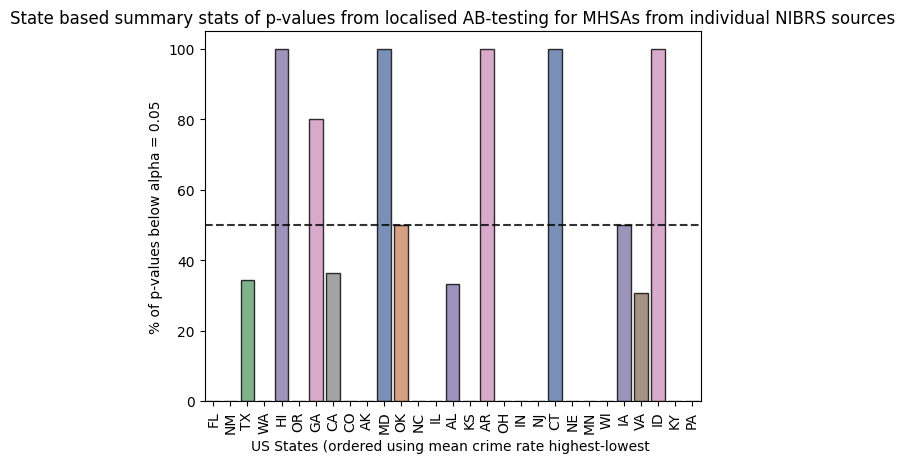

In [294]:
percent_per_state=(np.array(pvalue_percent_per_state).astype(float))*100.0
ax = sns.barplot(x=my_focus_states,y=percent_per_state,palette='deep',edgecolor='k',alpha=0.8)
ax = plt.xticks(rotation=90)
ax = plt.axhline(50.0,linestyle='--',c='k',alpha=0.8)
ax = plt.title('State based summary stats of p-values from localised AB-testing for MHSAs from individual NIBRS sources')
ax = plt.xlabel('US States (ordered using mean crime rate highest-lowest ')
ax = plt.ylabel('% of p-values below alpha = 0.05')

### Conclusion:
Recall $H_0$: "That there is no difference in means for an NIBRS agency crime data near an MHSA location before and after the date the MHSA status had been withdrawn."

This was tested for MHSAs in each state. For the majority of states, the alternative hypothesis is rejected. i.e., for each state The total percentage of t-tests that failed to reject the null hypothesis was below 50%. This suggests that there was no relationship between the improvement in the availability of mental health care providers in the shortage areas and the incidence of crime near those areas.

Indirectly, the results suggest that crime is not as influenced by the state of a person's mental health as we may be led to believe. It is more commonly assumed that criminal acts are performed by people whose mental health is degraded and requires diagnosis and treatment. This may not actually be the case.

We might have tried to identify a relation between the MHSA parameters  'Degree_of_Shortage' or 'HPSA_score' and crime rate; however, the NIBRS data does not have any population information so we cannot normalise the crime counts between agency locations. For future reference, it should be possible to obtain this information by other means of another API or even restrict the original HSPA search to entries which contain some population data.

### This is a good stage to migrate the data into Tableau and explore further visualisation possibilities.